In [1]:
import os
from os.path import expanduser
home_dir = expanduser("~")
module_path = home_dir + '/modules/'
import sys
sys.path.append(module_path)
import time
import importlib
import random
import tensorflow as tf
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
import model_management

np.random.seed(999)
random.seed(999)

/opt/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [13]:
### General parameters
run_on_cpu = False
total_set_size = 3000 # how many examples will be used for training+validation+testing
train_size = 1000
val_size = 1000
test_size = 1000
input_features = ['Halo_mass', 'Halo_mass_peak', 'Concentration', 'Halo_spin']
output_features = ['Stellar_mass', 'SFR']
nr_iters_before_restart_check = 60 # start making sure that the network did not converge to a local minimum
min_std_tol = 0.01 # minimum allowed std for any parameter
plot_threeD = 0
save_figs = 0
fig_dir = 'figures/'

### Network parameters
nLayers = 6 
activationFunction = 'tanh'
neuronsPerLayer = 8

### PSO parameters
nIterations = 1000
nParticles = 40
xMin = -10
xMax = 10
alpha = 1
deltaT = 1
c1 = 2
c2 = 2
inertiaWeightStart = 1.4
inertiaWeightMin = 0.3
explorationFraction = 0.8

data_dict = {'X_pos': 0, 'Y_pos': 1, 'Z_pos': 2, 'X_vel': 3, 'Y_vel': 4, 
             'Z_vel': 5, 'Halo_mass': 6, 'Stellar_mass': 7, 'SFR': 8, 
             'Intra_cluster_mass': 9, 'Halo_mass_peak': 10, 
             'Stellar_mass_obs': 11, 'SFR_obs': 12, 'Halo_radius': 13, 
             'Concentration': 14, 'Halo_spin': 15, 'Type': 16}
unit_dict = {'X_pos': '', 'Y_pos': '', 'Z_pos': '', 'X_vel': '', 'Y_vel': '', 
             'Z_vel': '', 'Halo_mass': 'log($M_{G}/M_{S}$)', 'Stellar_mass': 'log($M_{G}/M_{S}$)', 'SFR': '', 
             'Intra_cluster_mass': '', 'Halo_mass_peak': 'log($M_{G}/M_{S}$)', 
             'Stellar_mass_obs': '', 'SFR_obs': '', 'Halo_radius': '', 
             'Concentration': '', 'Halo_spin': '', 'Type': ''}

In [14]:
if run_on_cpu:
    os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [15]:
### Set name ending with parameters for figures to be saved
param_string = 'nLayers_%d_nNeurons_%d_actFun_%s_nTrainSamples_%d_nIterations_%d_' % (
    nLayers, neuronsPerLayer, activationFunction, train_size, nIterations)
print(param_string)

nLayers_6_nNeurons_8_actFun_tanh_nTrainSamples_1000_nIterations_1000_


# Load and preprocess the data

In [16]:
galfile = pd.read_hdf('/scratch/data/galcats/P200/galaxies.Z01.h5')
galaxies = galfile.as_matrix()
gal_header = galfile.keys().tolist()

### Remove data points with halo mass below 10.5
print(np.shape(galaxies))
galaxies = galaxies[galaxies[:,6] > 10.5, :]
print(np.shape(galaxies))
print(galaxies[:10,6])

halo_min_mass = np.min(galaxies[:, 6])
halo_max_mass = np.max(galaxies[:, 6])

(634742, 17)
(305382, 17)
[11.06128  10.74806  10.517851 11.935673 11.820144 11.564987 10.759135
 10.828308 10.803138 10.55098 ]


In [17]:
### Create the different data sets that will be used
n_data_points = galaxies.shape[0]
subset_indices = np.random.choice(n_data_points, total_set_size, replace=False)
train_indices = subset_indices[: train_size]
val_indices = subset_indices[train_size : train_size+val_size]
test_indices = subset_indices[train_size+val_size :]

x_train = np.zeros((len(train_indices), len(input_features)))
x_val = np.zeros((len(val_indices), len(input_features)))
x_test = np.zeros((len(test_indices), len(input_features)))
y_train = np.zeros((len(train_indices), len(output_features)))
y_val = np.zeros((len(val_indices), len(output_features)))
y_test = np.zeros((len(test_indices), len(output_features)))

for i in range(len(input_features)):
    x_train[:,i] = galaxies[train_indices, data_dict[input_features[i]]]
    x_val[:,i] = galaxies[val_indices, data_dict[input_features[i]]]
    x_test[:,i] = galaxies[test_indices, data_dict[input_features[i]]]
    
for i in range(len(output_features)):
    y_train[:,i] = galaxies[train_indices, data_dict[output_features[i]]]
    y_val[:,i] = galaxies[val_indices, data_dict[output_features[i]]]
    y_test[:,i] = galaxies[test_indices, data_dict[output_features[i]]]

In [18]:
### If you want to preprocess the data

for i in range(np.size(x_train, 1)):
    x_data_means = np.mean(x_train, 0)
    x_data_stds = np.std(x_train, 0)

    x_train_norm = (x_train - x_data_means) / x_data_stds
    x_val_norm = (x_val - x_data_means) / x_data_stds
    x_test_norm = (x_test - x_data_means) / x_data_stds

for i in range(np.size(y_train, 1)):
    y_data_means = np.mean(y_train, 0)
    y_data_stds = np.std(y_train, 0)

    y_train_norm = (y_train - y_data_means) / y_data_stds
    y_val_norm = (y_val - y_data_means) / y_data_stds
    y_test_norm = (y_test - y_data_means) / y_data_stds

In [19]:
print(np.mean(y_test_norm, 0))
print(np.std(y_test_norm, 0))

[ 0.01958106 -0.03366676]
[1.01262395 0.68155203]


In [20]:
### Get a feel for the data
for i in range(len(input_features)):
    print(input_features[i],': min: %.2e, max: %.2e.' % (np.min(x_train[:,i]), np.max(x_train[:,i])))
for i in range(len(output_features)):
    print(output_features[i],': min: %.2e, max: %.2e.' % (np.min(y_train[:,i]), np.max(y_train[:,i])))

Halo_mass : min: 1.05e+01, max: 1.37e+01.
Halo_mass_peak : min: 1.05e+01, max: 1.37e+01.
Concentration : min: 1.01e+00, max: 9.41e+02.
Halo_spin : min: 2.69e-03, max: 1.43e-01.
Stellar_mass : min: 7.00e+00, max: 1.15e+01.
SFR : min: 0.00e+00, max: 1.03e+01.


<IPython.core.display.Javascript object>


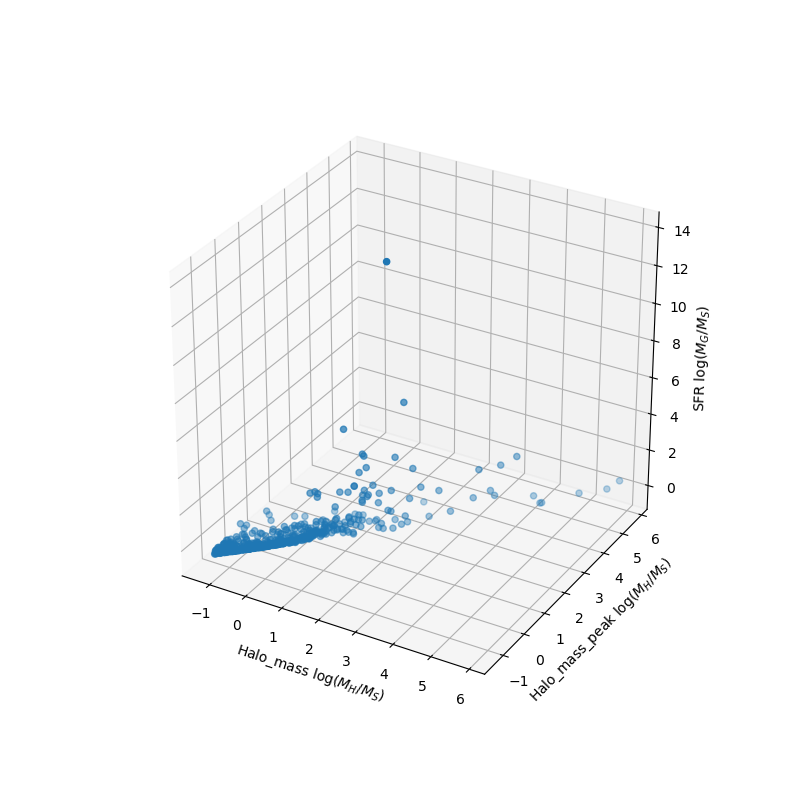

In [21]:
### Visualisation for when we have 2 input features
%matplotlib notebook
input_feat_1 = 0
input_feat_2 = 1
output_feat = 1

fig = plt.figure(1, figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_train_norm[:500,input_feat_1], x_train_norm[:500,input_feat_2], 
           y_train_norm[:500,output_feat])
ax.set_xlabel('%s log($M_{H}/M_{S}$)' % (input_features[input_feat_1]))
ax.set_ylabel('%s log($M_{H}/M_{S}$)' % (input_features[input_feat_2]))
ax.set_zlabel('%s log($M_{G}/M_{S}$)' % (output_features[output_feat]))
plt.show()

In [8]:
def InitialiseParticles(nParticles,xMin,xMax,nVariables,alpha,deltaT):
    
    r1 = np.random.uniform(size=(nParticles,nVariables))
    r2 = np.random.uniform(size=(nParticles,nVariables))
    
    positions = xMin + r1 * (xMax - xMin)
    velocities = alpha/deltaT * ((xMin - xMax)/2 + r2 * (xMax-xMin))
    
    return (positions, velocities)

In [9]:
def UpdateParticles(positions, velocities, particleBestPositions, 
                    swarmBestPosition, inertiaWeight, vMax, c1, c2, deltaT):
    
    nVariables = velocities.shape[1]
    
    q = np.random.uniform(size = (np.shape(positions)[0], 1))
    qMatrix = q
    r = np.random.uniform(size = (np.shape(positions)[0], 1))
    rMatrix = r
    for iVar in range(nVariables-1):
        qMatrix = np.concatenate((qMatrix, q), axis = 1)
        rMatrix = np.concatenate((rMatrix, r), axis = 1)
    
    particleBestDifference = particleBestPositions - positions
    swarmBestDifference = (positions - swarmBestPosition) * (-1)
    
    velocities = inertiaWeight*velocities + c1*qMatrix*particleBestDifference/deltaT + \
        c2*rMatrix*swarmBestDifference/deltaT
    
    # now limit velocities to vMax
    
    absVelocities = np.sqrt(np.sum(np.power(velocities, 2), axis=1))
    tooFastParticleIndeces = (absVelocities > vMax)
    
    notEmpty = np.any(tooFastParticleIndeces) # checks if at least one element is true
    
    if notEmpty:
        indices = np.argwhere(tooFastParticleIndeces)
        for index in indices:
            velocities[index,:] = velocities[index,:] * vMax / absVelocities[index]
            
    newPositions = positions + velocities * deltaT
    
    return (newPositions, velocities)

In [10]:
def EvaluateParticles(positions, inputDim, nLayers, neuronsPerLayer, outputDim, model, mode):
    
    particleScores = np.zeros(positions.shape[0])
    
    for iParticle in range(positions.shape[0]):
        
        (weightList, biasList) = ExtractWeights(positions[iParticle,:], inputDim, nLayers, neuronsPerLayer, outputDim)
        model = SetModelWeights(weightList, biasList, model)
        particleScores[iParticle] = EvaluateNN(model, mode)
    
    return particleScores

In [11]:
def ExtractWeights(variables, inputDim, nLayers, neuronsPerLayer, outputDim):
    
    weightList = [] # will contain a list of all the weight matrices 
    biasList = []   # will contain a list of all the biases

    weightCounter = 0 # to help assign weights and biases to their correct matrix

    ### Extract weight matrices
    weightMatrix = np.zeros((inputDim, neuronsPerLayer)) 
    for i in range(inputDim):  
        weightMatrix[i,:] = variables[weightCounter:weightCounter+neuronsPerLayer]
        weightCounter += neuronsPerLayer
    weightList.append(weightMatrix)


    for iLayer in range(nLayers-1):
        weightMatrix = np.zeros((neuronsPerLayer, neuronsPerLayer))
        for iNeuron in range(neuronsPerLayer):

            weightMatrix[iNeuron,:] = variables[weightCounter:weightCounter+neuronsPerLayer]
            weightCounter += neuronsPerLayer

        weightList.append(weightMatrix)

    weightMatrix = np.zeros((neuronsPerLayer, outputDim))
    for i in range(neuronsPerLayer):  
        weightMatrix[i,:] = variables[weightCounter:weightCounter+outputDim]
        weightCounter += outputDim

    weightList.append(weightMatrix)

    ### Extract bias vectors
    for iLayer in range(nLayers):

        biasVector = variables[weightCounter:weightCounter+neuronsPerLayer]
        weightCounter += neuronsPerLayer

        biasList.append(biasVector)

    biasVector = np.zeros((1,outputDim))
    biasVector = variables[weightCounter:weightCounter+outputDim] # for the output layer
    biasList.append(biasVector)

    weightCounter += outputDim

    #print(weightCounter, variables.shape[0])  # a check if the number of variables is correct
    return (weightList, biasList)
        

In [12]:
### Create model, weights will be updated later on
def CreateNN(inputDim, nLayers, neuronsPerLayer, outputDim, actFun = 'relu'):

    model = Sequential()
    model.add(Dense(neuronsPerLayer, input_dim = inputDim, activation = actFun))
    
    for i in range(0, nLayers-1):
        model.add(Dense(neuronsPerLayer, activation = actFun))
        
    model.add(Dense(outputDim, activation = None))
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
    
    return model

In [13]:
def EvaluateNN(model, mode):
    
    if mode == 'train':
        score = model.evaluate(x_train, y_train, verbose=0)
    elif mode == 'val':
        score = model.evaluate(x_val, y_val, verbose=0)
    elif mode == 'test':
        score = model.evaluate(x_test, y_test, verbose=0)
    else:
        print('incorrect evaluation mode provided (\'train\'/\'val\'/\'test\' required)')
    
    return score[1]

In [14]:
def SetModelWeights(weightList, biasList, model):
    
    for i in range(len(weightList)):
        model.layers[i].set_weights([weightList[i], biasList[i]])
        
    return model

In [15]:
def PredictFunc(weightList, biasList, model, mode):
    
    SetModelWeights(weightList, biasList, model)
    
    if mode == 'train':
        predictedY = model.predict(x_train)
    elif mode == 'val':
        predictedY = model.predict(x_val)
    elif mode == 'test':
        predictedY = model.predict(x_test)
    else:
        print('incorrect evaluation mode provided (\'train\'/\'val\'/\'test\' required)')
    
    return predictedY

In [16]:
### Run Particle Swarm Optimisation Algorithm

with open('progress.txt', 'w+') as f:
    
    f.write('PSO optimisation with %s\n\n' % (param_string))

    # make sure the output isn't just the same
    shouldStartFresh = 1
    while shouldStartFresh:
        shouldStartFresh = 0

        inputDim = len(input_features)
        outputDim = len(output_features)
        nVariables = inputDim * neuronsPerLayer + (nLayers-1) * neuronsPerLayer * neuronsPerLayer + \
            neuronsPerLayer * outputDim + nLayers * neuronsPerLayer + outputDim
        vMax = (xMax-xMin) / deltaT

        inertiaWeightReduction = np.exp(np.log(inertiaWeightMin/inertiaWeightStart) / explorationFraction / nIterations)
        inertiaWeight = inertiaWeightStart

        validationScoreHistory = []
        trainingScoreHistory = []
        lastTimeSwarmBest = 0
        swarmBest = 1e20
        swarmBestPosition = np.zeros(nVariables)
        particleBest = 1e20 * np.ones(nParticles)
        particleBestPositions = np.zeros((nParticles, nVariables))

        model = CreateNN(inputDim, nLayers, neuronsPerLayer, outputDim, activationFunction)
        (positions, velocities) = InitialiseParticles(nParticles, xMin,xMax,nVariables,alpha,deltaT)

        start = time.clock()
        for iteration in range(nIterations):
            if (int(iteration/10) == iteration/10):
                # see if network has run into a local minima
                if (iteration - lastTimeSwarmBest) > nr_iters_before_restart_check:
                    (bestWeightList, bestBiasList) = ExtractWeights(swarmBestPosition, inputDim, 
                                                        nLayers, neuronsPerLayer, outputDim)
                    predictedY = PredictFunc(bestWeightList, bestBiasList, model, 'test')
                    stds = np.std(predictedY, axis=0)
                    print(np.std(predictedY, axis=0))
                    shouldStartFresh = np.any(stds < min_std_tol)
                    if shouldStartFresh:
                        break

                print('Iteration %d.' % (iteration))
                f.write('Iteration %d.\n' % (iteration))
                f.flush()

            funcValues = EvaluateParticles(positions, inputDim, nLayers, neuronsPerLayer, outputDim, model, 'train')

            for iParticle in range(nParticles):

                isSwarmBest = (funcValues[iParticle] < swarmBest)
                #print(iParticle)
                #print(particleBest[iParticle])
                isParticleBest = (funcValues[iParticle] < particleBest[iParticle])

                if isSwarmBest:
                    lastTimeSwarmBest = iteration
                    swarmBestPosition = positions[iParticle,:]
                    particleBestPositions[iParticle,:] = positions[iParticle,:]
                    swarmBest = funcValues[iParticle]
                    particleBest[iParticle] = funcValues[iParticle]

                    (weightList, biasList) = ExtractWeights(swarmBestPosition, inputDim, nLayers, neuronsPerLayer, 
                                                            outputDim)
                    model = SetModelWeights(weightList, biasList, model)
                    valScore = EvaluateNN(model, 'val')
                    trainScore = EvaluateNN(model, 'train')
                    validationScoreHistory.append(valScore)
                    trainingScoreHistory.append(trainScore)

                    print('Iteration %d, new swarm best. Train: %.3f, Val: %.3f' % (iteration, swarmBest, valScore))
                    f.write('Iteration %d, new swarm best. Train: %.3f, Val: %.3f\n' % (iteration, swarmBest, valScore))
                    f.flush()
                    
                elif isParticleBest:
                    particleBestPositions[iParticle,:] = positions[iParticle,:]
                    particleBest[iParticle] = funcValues[iParticle]

            (positions, velocities) = UpdateParticles(positions,velocities,
                particleBestPositions,swarmBestPosition,inertiaWeight,vMax,c1,c2,deltaT)

            isExploring = (inertiaWeight > inertiaWeightMin)
            if isExploring:
                inertiaWeight = inertiaWeight * inertiaWeightReduction
                isExploring = (inertiaWeight > inertiaWeightMin)
                if not(isExploring):
                    print('SWITCH TO EPLOIT! Iteration %d/%d.' % (iteration, nIterations))
                    f.write('SWITCH TO EPLOIT! Iteration %d/%d.\n' % (iteration, nIterations))
                    f.flush()

end = time.clock()
(bestWeightList, bestBiasList) = ExtractWeights(swarmBestPosition, inputDim, nLayers, neuronsPerLayer, outputDim)
model = SetModelWeights(bestWeightList, bestBiasList, model)
testScore = EvaluateNN(model, 'test')
        

Iteration 0.
Iteration 0, new swarm best. Train: 1878.578, Val: 1885.330
Iteration 0, new swarm best. Train: 148.760, Val: 146.900
Iteration 0, new swarm best. Train: 144.482, Val: 142.649
Iteration 0, new swarm best. Train: 5.877, Val: 6.237
Iteration 0, new swarm best. Train: 2.428, Val: 2.623
Iteration 0, new swarm best. Train: 1.259, Val: 1.310
Iteration 5, new swarm best. Train: 1.253, Val: 1.302
Iteration 9, new swarm best. Train: 1.241, Val: 1.283
Iteration 10.
Iteration 12, new swarm best. Train: 1.231, Val: 1.258
Iteration 20.
Iteration 25, new swarm best. Train: 1.203, Val: 1.241
Iteration 27, new swarm best. Train: 0.503, Val: 0.532
Iteration 30.
Iteration 40.
Iteration 50.
Iteration 53, new swarm best. Train: 0.307, Val: 0.307
Iteration 60.
Iteration 70.
Iteration 80.
Iteration 90.
Iteration 100.
Iteration 110.
[0.8248042]
Iteration 120.
[0.8248042]
Iteration 130.
[0.8248042]
Iteration 140.
[0.8248042]
Iteration 150.
[0.8248042]
Iteration 160.
[0.8248042]
Iteration 170.
Ite

Iteration 467, new swarm best. Train: 0.107, Val: 0.127
Iteration 468, new swarm best. Train: 0.107, Val: 0.127
Iteration 469, new swarm best. Train: 0.107, Val: 0.127
Iteration 470.
Iteration 470, new swarm best. Train: 0.107, Val: 0.127
Iteration 470, new swarm best. Train: 0.107, Val: 0.127
Iteration 470, new swarm best. Train: 0.107, Val: 0.126
Iteration 471, new swarm best. Train: 0.107, Val: 0.126
Iteration 471, new swarm best. Train: 0.107, Val: 0.126
Iteration 472, new swarm best. Train: 0.107, Val: 0.126
Iteration 479, new swarm best. Train: 0.107, Val: 0.126
Iteration 480.
Iteration 480, new swarm best. Train: 0.107, Val: 0.126
Iteration 482, new swarm best. Train: 0.107, Val: 0.126
Iteration 483, new swarm best. Train: 0.107, Val: 0.126
Iteration 485, new swarm best. Train: 0.107, Val: 0.126
Iteration 485, new swarm best. Train: 0.107, Val: 0.126
Iteration 486, new swarm best. Train: 0.107, Val: 0.126
Iteration 486, new swarm best. Train: 0.107, Val: 0.126
Iteration 487, new

Iteration 532, new swarm best. Train: 0.106, Val: 0.123
Iteration 532, new swarm best. Train: 0.106, Val: 0.123
Iteration 532, new swarm best. Train: 0.106, Val: 0.123
Iteration 533, new swarm best. Train: 0.106, Val: 0.123
Iteration 533, new swarm best. Train: 0.106, Val: 0.123
Iteration 533, new swarm best. Train: 0.106, Val: 0.123
Iteration 534, new swarm best. Train: 0.106, Val: 0.124
Iteration 534, new swarm best. Train: 0.106, Val: 0.123
Iteration 534, new swarm best. Train: 0.106, Val: 0.123
Iteration 535, new swarm best. Train: 0.106, Val: 0.123
Iteration 535, new swarm best. Train: 0.106, Val: 0.123
Iteration 535, new swarm best. Train: 0.106, Val: 0.123
Iteration 536, new swarm best. Train: 0.106, Val: 0.123
Iteration 536, new swarm best. Train: 0.106, Val: 0.123
Iteration 536, new swarm best. Train: 0.106, Val: 0.123
Iteration 536, new swarm best. Train: 0.106, Val: 0.123
Iteration 537, new swarm best. Train: 0.106, Val: 0.123
Iteration 537, new swarm best. Train: 0.106, Val

Iteration 588, new swarm best. Train: 0.102, Val: 0.120
Iteration 588, new swarm best. Train: 0.102, Val: 0.119
Iteration 589, new swarm best. Train: 0.102, Val: 0.120
Iteration 589, new swarm best. Train: 0.102, Val: 0.119
Iteration 589, new swarm best. Train: 0.102, Val: 0.119
Iteration 590.
Iteration 590, new swarm best. Train: 0.102, Val: 0.119
Iteration 591, new swarm best. Train: 0.102, Val: 0.119
Iteration 591, new swarm best. Train: 0.102, Val: 0.119
Iteration 591, new swarm best. Train: 0.102, Val: 0.119
Iteration 591, new swarm best. Train: 0.102, Val: 0.119
Iteration 591, new swarm best. Train: 0.102, Val: 0.119
Iteration 592, new swarm best. Train: 0.102, Val: 0.119
Iteration 592, new swarm best. Train: 0.102, Val: 0.119
Iteration 592, new swarm best. Train: 0.101, Val: 0.119
Iteration 593, new swarm best. Train: 0.101, Val: 0.118
Iteration 594, new swarm best. Train: 0.101, Val: 0.118
Iteration 594, new swarm best. Train: 0.101, Val: 0.118
Iteration 594, new swarm best. Tr

In [17]:
print('Lowest mse:\nTraining: %.3e, validation : %.3e,' % (min(trainingScoreHistory),min(validationScoreHistory)))
print("time elapsed: %.2fmin" % ((end - start)/60))

Lowest mse:
Training: 9.821e-02, validation : 1.138e-01,
time elapsed: 103.62min


In [18]:
### Visualisation of prediction strength for when we have 2 input features
if plot_threeD and len(input_features) == 2:
    predictedY = PredictFunc(bestWeightList, bestBiasList, model, 'test')
    fig = plt.figure(2, figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x_test[:,0], x_test[:,1], 
               y_test[:,0], s=3)
    ax.scatter(x_test[:,0], x_test[:,1], 
               predictedY, s=3)
    ax.set_xlabel('%s log($M_{H}/M_{S}$)' % (input_features[0]))
    ax.set_ylabel('%s log($M_{H}/M_{S}$)' % (input_features[1]))
    ax.set_zlabel('%s log($M_{G}/M_{S}$)' % (output_features[0]))

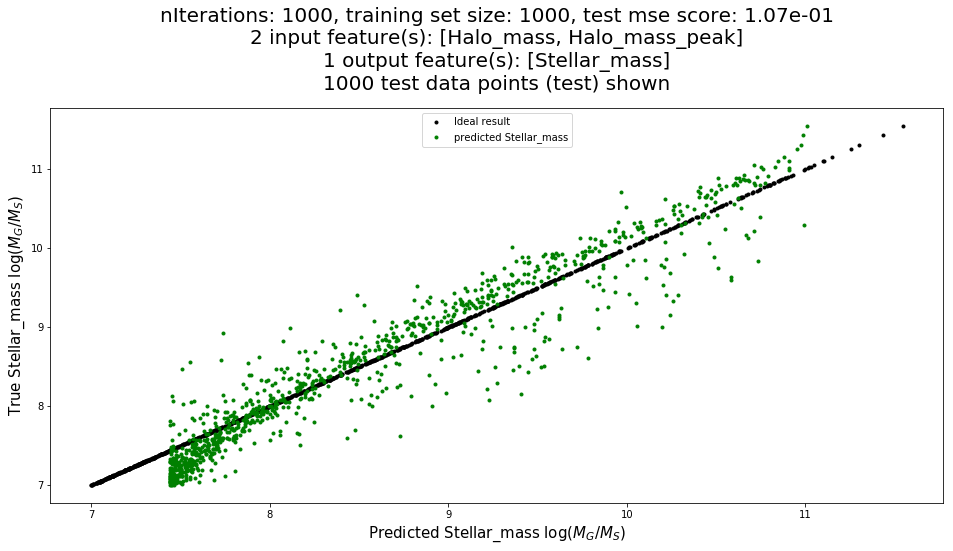

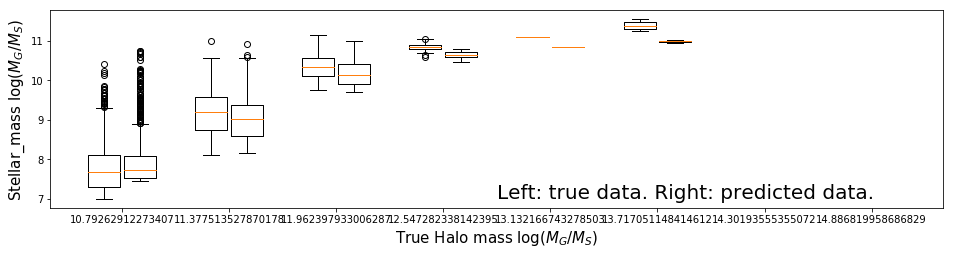

In [21]:
%matplotlib inline
nBins = 8
bin_edges = np.linspace(halo_min_mass, halo_max_mass, nBins+1)

predictedY = model.predict(x_test)

for i, feat in enumerate(output_features):
    
    
    ### Plot 1
    fig = plt.figure(figsize=(16,16))
    ax = plt.subplot(211)
    plt.plot(y_test[:,i], y_test[:,i], 'k.')
    plt.plot(predictedY[:,i], y_test[:,i], 'g.')
    plt.ylabel('True %s %s' % (feat, unit_dict[feat]), fontsize=15)
    plt.xlabel('Predicted %s %s' % (feat, unit_dict[feat]), fontsize=15)
    plt.legend(['Ideal result', 'predicted ' + feat], loc='upper center')
    plt.title('nIterations: %d, training set size: %d, test mse score: %.2e\n' % (nIterations, 
        train_size, testScore) + 
        '%d input feature(s): [%s]\n%d output feature(s): [%s]\n%d test data points (test) shown' % (
        len(input_features), ', '.join(input_features), len(output_features), ', '.join(output_features),
        test_size), y=1.03, fontsize=20)
    plt.show
        
    if save_figs:
        fig.savefig(fig_dir+'pso_output_scatter_%d_plot_from_' % (i+1)+'_and_'.join(input_features)+'_to_'+
            '_and_'.join(output_features)+'_with_'+param_string+'.png', bbox_inches = 'tight')
    
    ### Plot 2 - boxplot
    
    # bin_means contain (0: mean of the binned values, 1: bin edges, 2: numbers pointing each example to a bin)
    bin_means_true = stats.binned_statistic(x_test[:,i], y_test[:,i], bins=bin_edges)
    bin_means_pred = stats.binned_statistic(x_test[:,i], predictedY[:,i].flatten(), bins=bin_edges)
    bin_centers = []
    for iBin in range(nBins):
        bin_centers.append((bin_means_true[1][iBin] + bin_means_true[1][iBin+1]) / 2)
    sorted_true_y_data = []
    sorted_pred_y_data = []
    for iBin in range(1,nBins+1):
        sorted_true_y_data.append(y_test[bin_means_true[2] == iBin, i])
        sorted_pred_y_data.append(predictedY[bin_means_pred[2] == iBin,i])
    
    fig = plt.figure(figsize=(16,8))
    ax = plt.subplot(212)

    bin_pos = np.array([-2,-1]) # (because this makes it work)
    x_label_centers = []
    for iBin in range(nBins):
        # Every boxplot adds 2 boxes, one from the true data and one from the predicted data
        bin_pos += 3 
        plt.boxplot([sorted_true_y_data[iBin], sorted_pred_y_data[iBin]] , positions = bin_pos, widths = 0.9)
        x_label_centers.append(np.mean(bin_pos))
    
    plt.ylabel('%s %s' % (feat, unit_dict[feat]), fontsize=15)
    plt.xlabel('True Halo mass log($M_{G}/M_{S}$)', fontsize=15)
    ax.set_xlim(left=x_label_centers[0]-2, right=x_label_centers[-1]+2)
    #xlim(0,bin_pos[1] + 1)
    plt.xticks(x_label_centers, bin_centers) TODO fixa siffrorna
    plt.text(12,7,'Left: true data. Right: predicted data.', fontsize=20)
    
    if feat == 'SFR':
        ax.axhline(y=0, linestyle='--')
    
    #plt.title('nIterations: %d, training set size: %d, test mse score: %.2e\n' % (nIterations, 
    #    train_size, testScore) + 
    #    '%d input feature(s): [%s]\n%d output feature(s): [%s]\n%d test data points (test) shown' % (
    #    len(input_features), ', '.join(input_features), len(output_features), ', '.join(output_features),
    #    test_size), y=1.03, fontsize=20)
    
    plt.show()
    
    if save_figs:
        fig.savefig(fig_dir+'pso_output_boxplot_%d_from_' % (i+1)+'_and_'.join(input_features)+'_to_'+
            '_and_'.join(output_features)+'_with_'+param_string+'.png', bbox_inches = 'tight')

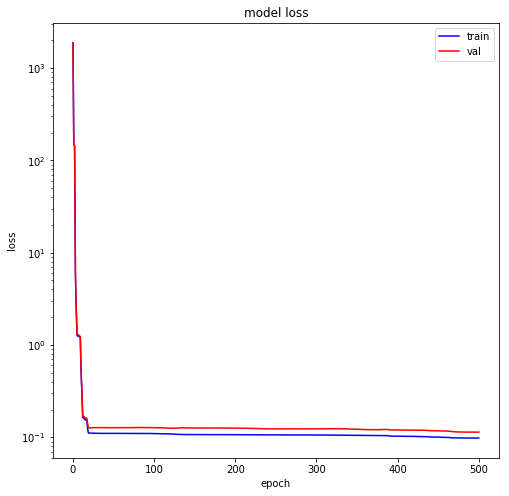

In [20]:
# Summarize history for loss
%matplotlib inline
fig = plt.figure(5, figsize=(8,8))
plt.plot(trainingScoreHistory, 'b')
plt.plot(validationScoreHistory, 'r')
plt.yscale('log')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()